<a href="https://www.kaggle.com/code/rickyzou/nlp-for-mental-health-text-data?scriptVersionId=131273994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text Analytics for Mental Health

## Background
Over the last decade, we've seen a tremendous increase in mental health issues arise across the global landscape. More and more children and adults are experiencing various kinds of mental health related obstacles throughout their day-to-day lives. However, just like how the Internet and the digital world it has birthed changed the way we carry out essential daily tasks such as communicating with one another, working our jobs, and purchasing goods & services, digital tools such as chatbots and recommendation engines can transform the way we handle mental health troubles. These tools need to be effectively trained on high quality data in order to engage in meaningful interactions. Hence, in this project I use various Natural Language Processing techniques to analyze a text-heavy dataset centered around mental health. This project was inspired by [this article]("https://towardsdatascience.com/counsel-chat-bootstrapping-high-quality-therapy-data-971b419f33da"). The data was taken from the associated [Github repository]("https://github.com/nbertagnolli/counsel-chat").(Note: Code for the 2 visualizations in the "EDA" section and the 2 handy functions for data visualization were taken directly from the Github repo)

The data was scraped from [counselchat.com]("https://counselchat.com/"), an online forum providing users with an expert community of mental health professionals that seek to assist users with their personal struggles. Users can submit a question pertaining to a specific mental health topic and get responses from various mental health professionals. Users can read questions and responses of other users in addition to the response(s) they recieved on their own question(s), and can leave an upvote, or "like", on any response they deem worthy. The relevant columns of the dataset I examined are as follows:
- questionText: The content of the actual question posted
- Topic: The specific mental health topic the question is listed under
- answerText: The content of the therapist's response to the question
- Upvotes: The number of upvotes the response from the "answerText" column recieved (if any)

## Research Questions
While there are countless angles to approach this dataset, I focused on the following 3 research questions:
1. What can we learn from the most significant words of various mental health topics?
2. How well can we predict whether or not a response recieved an upvote, and is a more complex machine learning model better than a simpler one in performing this task?
3. How well can a simple machine learning model classify a response to its respective topic?

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/nbertagnolli/counsel-chat/master/data/20200325_counsel_chat.csv')
data.drop(axis=1, labels='Unnamed: 0', inplace=True)

## EDA

In [3]:
# Number of total responses
data.shape

# Note that each row showcases a question and an associated response. Each row represents a unique response to the question, so if a particular question recieved multiple responses, then one row would highlight one response

(2129, 11)

In [4]:
# Count of therapist responses to each question
data['questionID'].value_counts()

1      49
12     49
10     45
11     42
17     27
       ..
545     1
544     1
543     1
542     1
327     1
Name: questionID, Length: 815, dtype: int64

In [5]:
# Number of counselors
data.groupby("therapistURL").agg("count").shape

(307, 10)

In [6]:
# Number of topics
len(set(data["topic"].tolist()))

31

In [7]:
# Number of unique questions
len(set(data["questionID"].tolist()))

815

In [8]:
# Average number of responses to questions
data.groupby("questionLink").agg("count")["questionID"].describe()

# In general, most questions have only a few (around two) responses with 75% of questions having two or fewer total responses.

count    824.000000
mean       2.583738
std        4.982621
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       94.000000
Name: questionID, dtype: float64

In [9]:
# Getting a sense of our "upvotes" column
data["upvotes"].describe()

# A decent number of responses did not even recieve a single upvote

count    2129.000000
mean        0.489901
std         0.942429
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: upvotes, dtype: float64

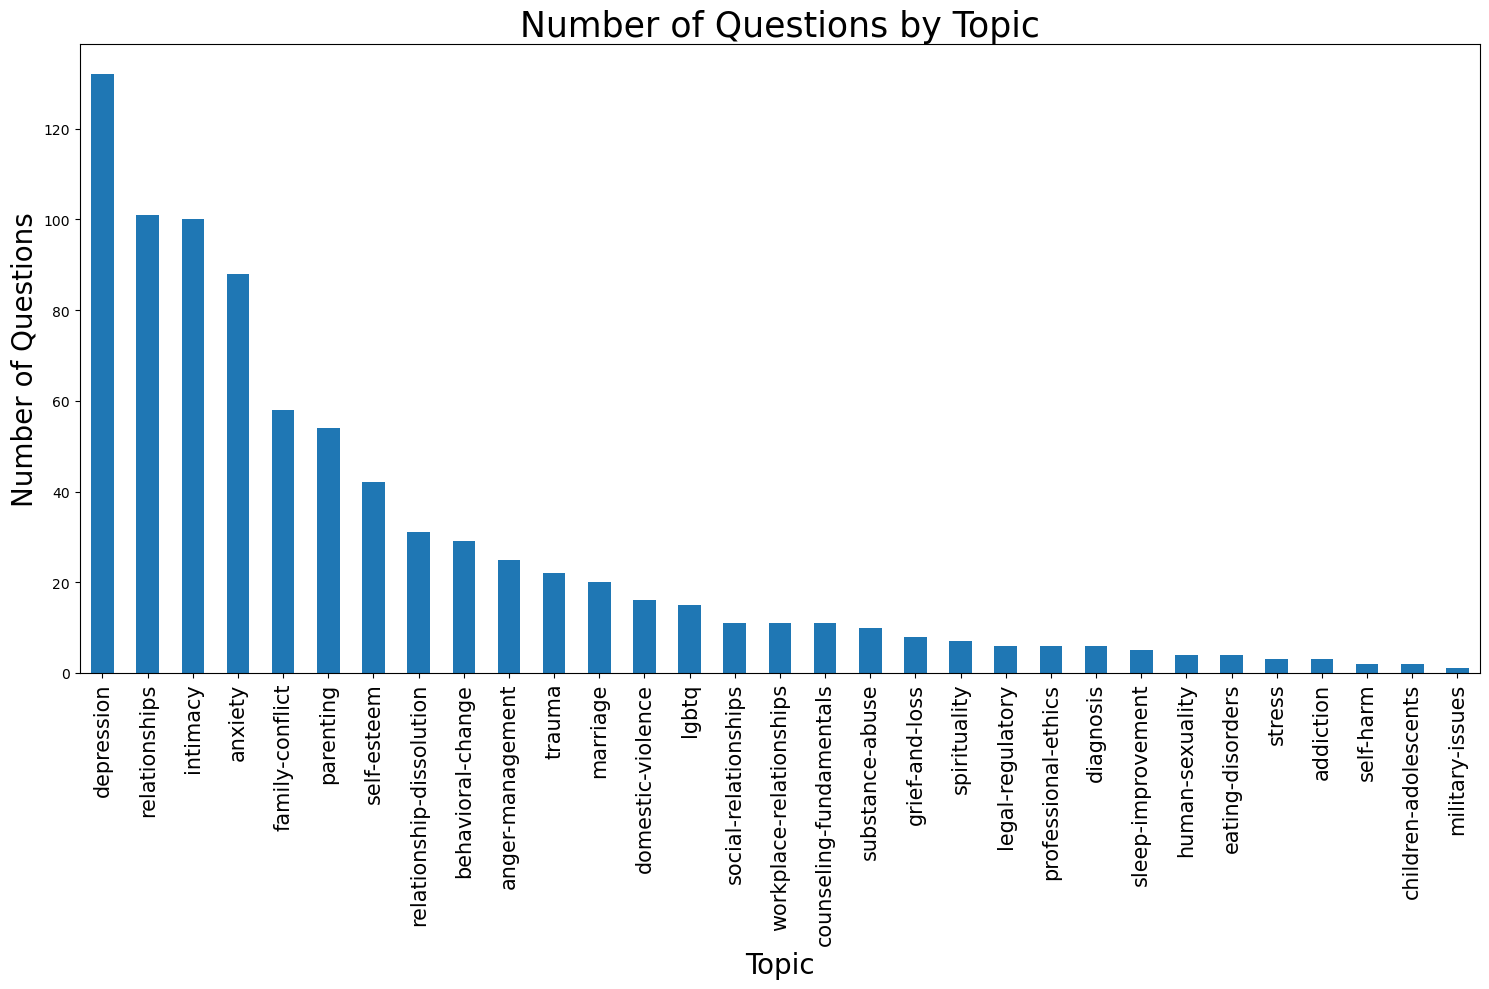

In [10]:
# Distribution of questions by topic
fig, ax = plt.subplots(figsize=(15, 10))
data.groupby(["topic", "questionID"]).agg("count").reset_index().groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Questions by Topic", fontsize=25)
ax.set_ylabel("Number of Questions", fontsize=20)
ax.set_xlabel("Topic", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
plt.tight_layout()

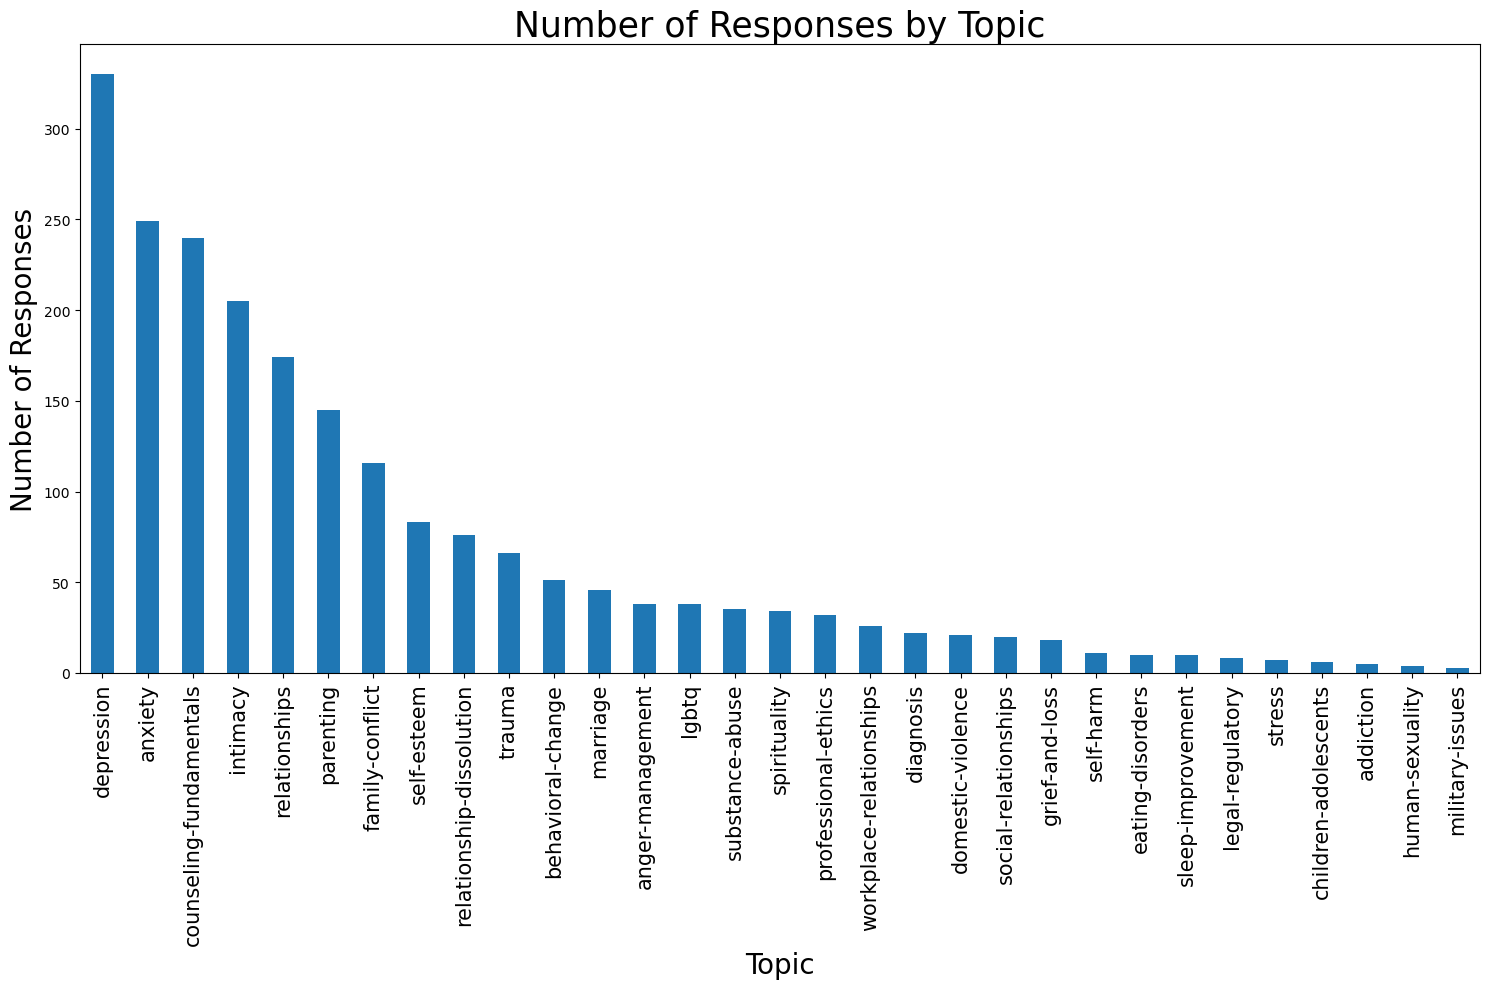

In [11]:
# Distribution of answers by topic
fig, ax = plt.subplots(figsize=(15, 10))
data.groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Responses by Topic", fontsize=25)
ax.set_xlabel("Topic", fontsize=20)
ax.set_ylabel("Number of Responses", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
plt.tight_layout()

We can see that the following 4 mental health topics are shared in the top 5 topics between the 2 different visualizations:

- Depression
- Anxiety
- Intimacy
- Relationships

## TF-IDF Analysis

In [12]:
# Loading the "englisgh-web-dataset small" pipline. This is a pre-trained model from the spacy library

nlp = spacy.load("en_core_web_sm")

In [13]:
# Function to breakdown the various aspects of the text

def process(nlp, text,
           cols=['lower_', 'pos_', 'is_stop', 'is_space', 'is_ascii',
             'is_digit', 'is_punct', 'text', 'lemma_'],
           labelcol=None, textcol=None):
    
    if not isinstance(text, pd.DataFrame):
        doc = nlp(str(text))
        df = pd.DataFrame()
        for col in cols:
            df[col] = [getattr(token, col) for token in doc]
            
        return df
    
    else:
        text_df = None
        df = None
        for index, row in text.iterrows(): 
            text_df = process(nlp, row[textcol])
            text_df[labelcol] = [row[labelcol]]*len(text_df)
            if (type(df) != None):
                df = pd.concat([df, text_df], axis=0)
            else:
                df = text_df
                
        cols.insert(0,labelcol)
        df = df[cols]
        cols.pop(0)
        
        return df

In [14]:
df = process(nlp, data, labelcol="topic", textcol="answerText")

In [15]:
# Word counting

counts = df.groupby("topic")["lower_"].value_counts(normalize=True)
counts = counts[counts > 0.001]
counts.name = "tf"
counts = counts.reset_index()

In [16]:
# Here, we will normalize our counted values by the number of documents for each topic.
# Note that we're using ".value_counts()" on the list of counts themselves because that will tell us which topics each word appears in

# How many topics are there?
num_topics = len(set(counts["topic"]))

# Calculate Document Frequency by doing: count(word in topics) / number of topics
doc_fre = counts["lower_"].value_counts()/num_topics

doc_fre.name = "df"
doc_fre = doc_fre.reset_index()

In [17]:
# We then join this back to the tf dataframe using the words as the way to match them

tf = counts
tf.index = tf["lower_"]
doc_fre.index = doc_fre["index"]

new = tf.join(doc_fre).reset_index()[["topic", "index", "tf", "df"]]

In [18]:
# Calculating TF-IDF

new["tfidf"] = new["tf"]*np.log(1/new["df"])
new = new.sort_values("tfidf", ascending=False)

In [19]:
# Finding the highest single TF-IDF word by topic

new.loc[new.groupby("topic")["tfidf"].idxmax()]

,topic,index,tf,df,tfidf
288,addiction,12,0.005579,0.032258,0.019158
592,anger-management,anger,0.008294,0.096774,0.019369
611,anxiety,anxiety,0.006423,0.129032,0.013152
925,behavioral-change,bipolar,0.001953,0.032258,0.006708
3766,children-adolescents,school,0.011852,0.161290,0.021624
1122,counseling-fundamentals,client,0.005003,0.096774,0.011685
1300,depression,depression,0.003748,0.096774,0.008753
3478,diagnosis,personality,0.003099,0.032258,0.010643
413,domestic-violence,abusive,0.003018,0.032258,0.010362
1715,eating-disorders,food,0.009312,0.032258,0.031977


The table above presents the top TF-IDF word for each topic based on the method deployed. This information provides a solid starting point if we want to take a closer look at any particular topic. For example, we can see that “smoking” is the top word for the “substance-abuse” topic, which indicates that within this sample size, the majority of individuals struggling with substance abuse discuss their difficulties with smoking. Another interesting top word relative to its topic is “boyfriend” to the “relationships” topic. We can infer that the majority of individuals seeking help for their relationships are those with boyfriends, and the majority of individuals with boyfriends are women. Researchers can dive deeper into the disparity between women and men seeking professional help with their relationships. Additionally, the word “husband” is the top TF-IDF word for both the “marriage” and “self-harm” topics. The male counterpart of a relationship seems to be the topic of discussion for a lot of queries within this topic domain.

### Word Clouds
As mentioned earlier, the top 4 topics in this dataset are Depression, Anxiety, Intimacy, and Relationships, and there happens to be an overlap between the 2 topic pairings consisting of Depression & Anxiety and Intimacy & Relationships. Hence, we will compare the top 8-10 TF-IDF words for each topic pairing

- Comparing the top words in Depression and Anxiety
- Comparing the top words in Intimacy and Relationships

In [20]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [21]:
# Top 10 in "Depression"

dep = new.loc[new["topic"] == "depression"][0:13]
dep.drop([1270,3575,5300], inplace=True)

# Top 10 in "Anxiety"

anx = new.loc[new["topic"] == "anxiety"][0:15]
anx.drop([291,1269,5299,1,3573], inplace=True)

In [22]:
# Top 10 in "Intimacy"

intimacy = new.loc[new["topic"] == "intimacy"][0:10]

# Top 10 in "Relationships"

rel = new.loc[new["topic"] == "relationships"][0:10]

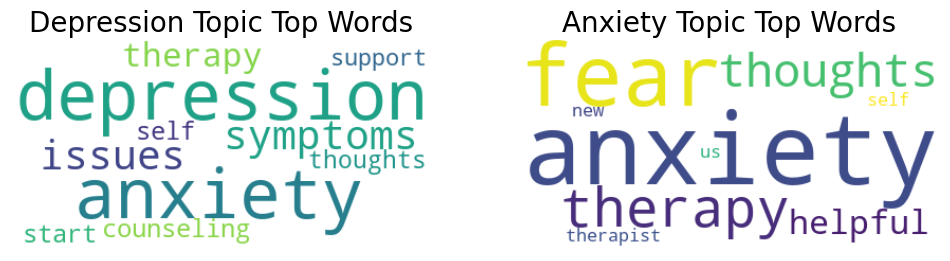

In [23]:
# Word cloud for depression
text = " ".join(word for word in dep['index'])
wc = WordCloud(background_color="white").generate(text)
wc.recolor(random_state=10)

# Word cloud for anxiety
text1 = " ".join(word for word in anx['index'])
wc1 = WordCloud(background_color="white").generate(text1)
wc1.recolor(random_state=8)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(wc, interpolation='bilinear')
axes[0].set_title("Depression Topic Top Words", fontsize=20, color="black")
axes[0].axis('off')

axes[1].imshow(wc1, interpolation='bilinear')
axes[1].set_title("Anxiety Topic Top Words", fontsize=20, color="black")
axes[1].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the subplots
plt.show()

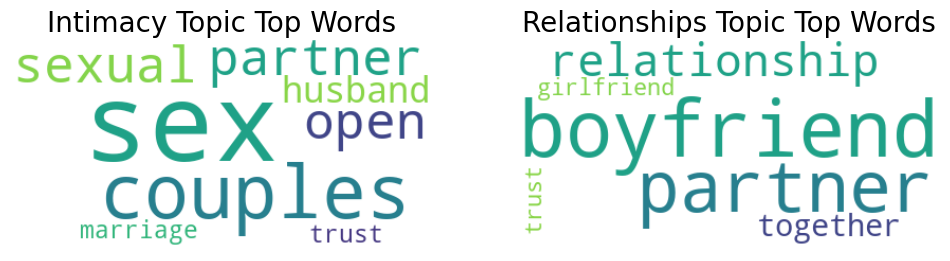

In [24]:
# Word cloud for intimacy
text2 = " ".join(word for word in intimacy['index'])
wc2 = WordCloud(background_color="white").generate(text2)
wc2.recolor(random_state=10)

# Word cloud for relationships
text3 = " ".join(word for word in rel['index'])
wc3 = WordCloud(background_color="white").generate(text3)
wc3.recolor(random_state=10)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(wc2, interpolation='bilinear')
axes[0].set_title("Intimacy Topic Top Words", fontsize=20, color="black")
axes[0].axis('off')

axes[1].imshow(wc3, interpolation='bilinear')
axes[1].set_title("Relationships Topic Top Words", fontsize=20, color="black")
axes[1].axis('off')

plt.subplots_adjust(wspace=0.2)

plt.show()

The 2 pairings of word clouds between Depression & Anxiety and Intimacy & Relationships highlights how much overlap the topcs in each topic pairing have with one another. They share many top words with which can pose an issue for topic classification tasks as we will see in our topic classification section. 

### Defining a few functions for data visualization

In [25]:
from typing import Dict, Any, Callable, List, Tuple, Optional, Union
from sklearn import metrics

In [26]:
# Function to compute various metrics of the model and returns a dataframe containing the information

def calculate_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    average: Optional[str] = None,
    return_df: bool = True,
) -> Union[Dict[str, float], pd.DataFrame]:
    """Computes f1, precision, recall, kappa, accuracy, and support
    Args:
        y_true: The true labels
        y_pred: The predicted labels
        average: How to average multiclass results
        return_df: Returns a dataframe if true otherwise a dictionary of performance
            values.
    Returns:
        Either a dataframe of the performance metrics or a single dictionary
    """
    labels = unique_labels(y_true, y_pred)

    # get results
    precision, recall, f_score, support = metrics.precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=average
    )

    kappa = metrics.cohen_kappa_score(y_true, y_pred, labels=labels)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    # create a pandas DataFrame
    if return_df:
        results = pd.DataFrame(
            {
                "class": labels,
                "f_score": f_score,
                "precision": precision,
                "recall": recall,
                "support": support,
                "kappa": kappa,
                "accuracy": accuracy,
            }
        )
    else:
        results = {
            "f1": f_score,
            "precision": precision,
            "recall": recall,
            "kappa": kappa,
            "accuracy": accuracy,
        }

    return results

In [27]:
def visualize_performance(
        df: pd.DataFrame,
        metrics: List[str],
        ax: Optional[Any] = None,
        title: Optional[str] = None,
        ylim: Optional[Tuple[float, float]] = None,
        figsize: Optional[Tuple[int, int]] = None,
        use_class_names: bool = True
) -> None:
    """Takes a Performance DF and converts it to a bar plot performance graph
    Args:
        df: A dataframe where each row is a class and each column is a metric
        metrics: A list of metrics from the columns of df to plot
        ax: A matplotlib axes object that we want to draw the plot on
        title: The title of the plot
        ylim: The minimum and maximum range for the yaxis.
        figsize: The width and height of the figure.  This does nothing if ax is set
        use_class_names: This will label the x ticks with the class name in a multiclass setting.
    """
    unstacked_df = (
        df[metrics]
            .T.unstack()
            .reset_index()
            .rename(
            index=str, columns={"level_0": "class", "level_1": "metric", 0: "score"}
        )
    )

    if use_class_names:
        unstacked_df["class"] = unstacked_df["class"].apply(
            lambda x: df["class"].tolist()[x]
        )

    if figsize is None:
        figsize = (10, 7)

    # Diplay the graph
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    sns.barplot(x="class", y="score", hue="metric", data=unstacked_df, ax=ax)

    # Format the graph
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
    ax.set_xlabel("Topic", fontsize=16)
    ax.set_ylabel("Score", fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=20)

    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()

## Upvote Prediction

In [28]:
# Adding a column "gotUpvote" to denote whether or not a response received an upvote
# This column will be our response variable in our prediction task
def upvote(x):
    return 1 if int(x) > 0 else 0

data["gotUpvote"] = data["upvotes"].apply(upvote)

# Seeing the percentage of responses that received at least 1 upvote
data["gotUpvote"].sum() / len(data)

0.3104744011272898

### Naive Bayes Classifier

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

In [30]:
# Using GridSearch to enhance performance

X = data["answerText"]
y = data["gotUpvote"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


cv = CountVectorizer(max_features=10000, stop_words="english")
X_train = cv.fit_transform(X_train)

tfidf = TfidfTransformer(use_idf=True)
X_train = tfidf.fit_transform(X_train)

X_test = cv.transform(X_test)
X_test = tfidf.transform(X_test)

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

clf = GridSearchCV(MultinomialNB(), param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]})

In [31]:
# Using best alpha value

best_clf = clf.best_estimator_
best_clf.fit(X_train, y_train)

y_pred_train = best_clf.predict(X_train)
y_pred_test = best_clf.predict(X_test)

In [32]:
# Metrics for training data

print(f'Accuracy score: {accuracy_score(y_train, y_pred_train)}')
print(classification_report(y_train, y_pred_train))

Accuracy score: 0.9248385202583675
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1184
           1       0.99      0.76      0.86       519

    accuracy                           0.92      1703
   macro avg       0.95      0.88      0.90      1703
weighted avg       0.93      0.92      0.92      1703



In [33]:
# Metrics for testing data

print(f'Accuracy score: {accuracy_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Accuracy score: 0.704225352112676
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       284
           1       0.74      0.18      0.28       142

    accuracy                           0.70       426
   macro avg       0.72      0.57      0.55       426
weighted avg       0.71      0.70      0.64       426



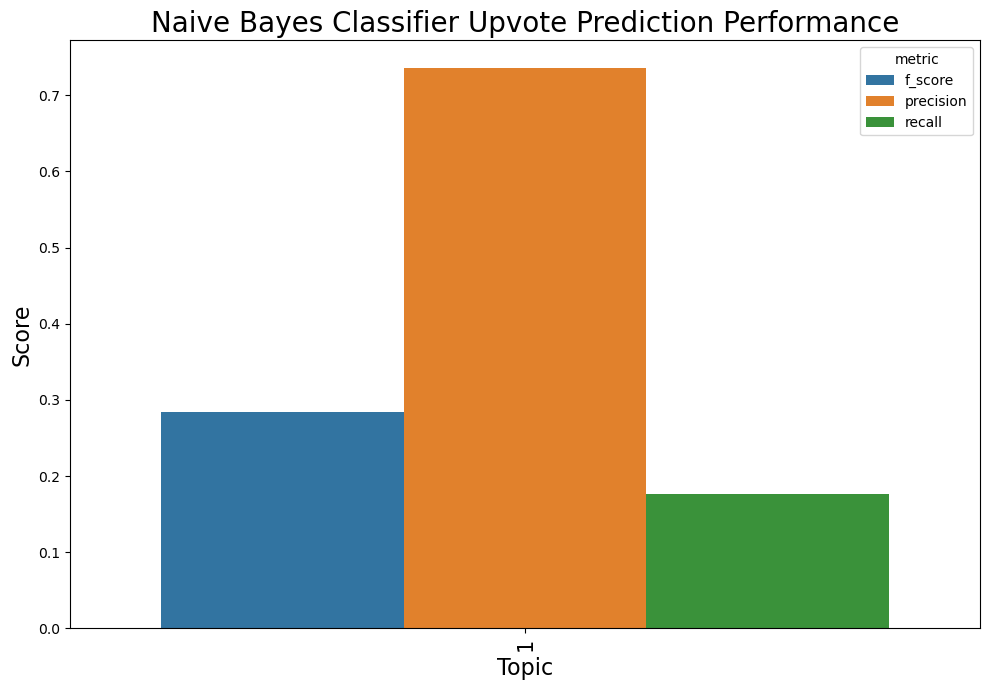

In [34]:
nb_perf_df = calculate_classification_metrics(y_test, y_pred_test)
nb_viz = visualize_performance(nb_perf_df[nb_perf_df["class"] == 1],
                              ["f_score", "precision", "recall"],
                              use_class_names=False,
                              title="Naive Bayes Classifier Upvote Prediction Performance")

### Microsoft DeBerta Language Transformer

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sentencepiece
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
import random
import torch

In [36]:
# Setting random seeds for consistency

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [37]:
data_copy = data.copy()

In [38]:
# Changing the data type of our response column to floats for compatibility

data_types_dict = {'gotUpvote': float}

data_copy["gotUpvote"] = data_copy["gotUpvote"].astype(data_types_dict)

In [39]:
data_copy.rename({"answerText":"input"}, axis=1, inplace=True)

In [40]:
# Creating a data subset with the desired columns for analysis
up_data = data_copy[['input', 'gotUpvote']]

In [41]:
ds = Dataset.from_pandas(up_data)

In [42]:
model_nm = 'microsoft/deberta-v3-small'

In [43]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
# Simple function which tokenizes our inputs

def tok_func(x):
    return tokz(x["input"])

# Applying the function in parallel on every row in our dataset
# This adds a new item to our dataset called "input_ids"

tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [45]:
# Renaming our response variable column (gotUpvote) to "labels" for compatibility

tok_ds = tok_ds.rename_columns({'gotUpvote':'labels'})

In [46]:
tok_ds

Dataset({
    features: ['input', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2129
})

In [47]:
dsd = tok_ds.train_test_split(0.25, seed=42)

In [48]:
# Picking a batch size and number of epochs for runtime optimization
# We have a large number of tokens in our text dataset, so I've set our batch size and epoch numbers relatively small so the model can run

bs = 2
epochs = 1

# Declaring a learning rate

lr = 9e-5

In [49]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=False,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [50]:
def corr(x,y):
    return np.corrcoef(x,y)[0][1]

def corr_d(eval_pred):
    return {'pearson': corr(*eval_pred)}

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dsd['train'], eval_dataset=dsd['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [52]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
1,0.252400,0.209510,0.238707


TrainOutput(global_step=798, training_loss=0.24614560693726503, metrics={'train_runtime': 81.8434, 'train_samples_per_second': 19.501, 'train_steps_per_second': 9.75, 'total_flos': 113483113293840.0, 'train_loss': 0.24614560693726503, 'epoch': 1.0})

In [53]:
preds = trainer.predict(dsd['test']).predictions.astype(float)

In [54]:
np.mean(preds)

0.25484487137584255

In [55]:
# The predictions of the transformer model are represented in probabilities instead of 0's and 1's, so I simply assigned a value of "1" to the predictions with a probability greater than the mean and a "0" to those with a probability less than the mean
binary_preds = np.where(preds>np.mean(preds), 1, 0)

In [56]:
trans_perf_df = calculate_classification_metrics(dsd['test']['labels'], binary_preds)
trans_perf_df

,class,f_score,precision,recall,support,kappa,accuracy
0,0.0,0.736842,0.784848,0.69437,373,0.232759,0.652908
1,1.0,0.490358,0.438424,0.55625,160,0.232759,0.652908


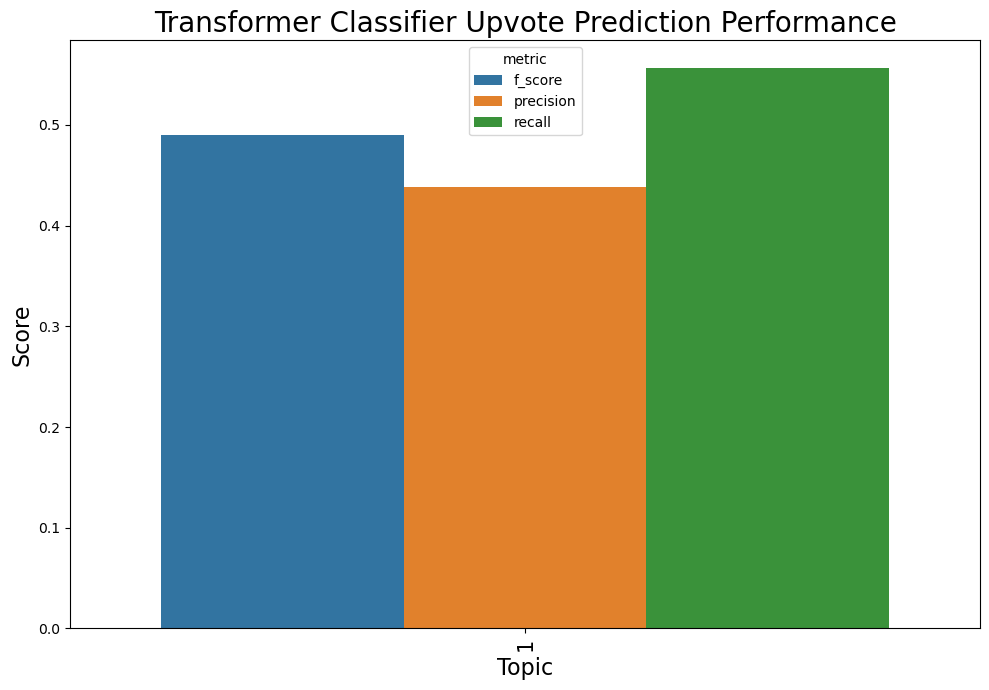

In [57]:
trans_viz = visualize_performance(trans_perf_df[trans_perf_df["class"] == 1],
                              ["f_score", "precision", "recall"],
                              use_class_names=False,
                              title="Transformer Classifier Upvote Prediction Performance")

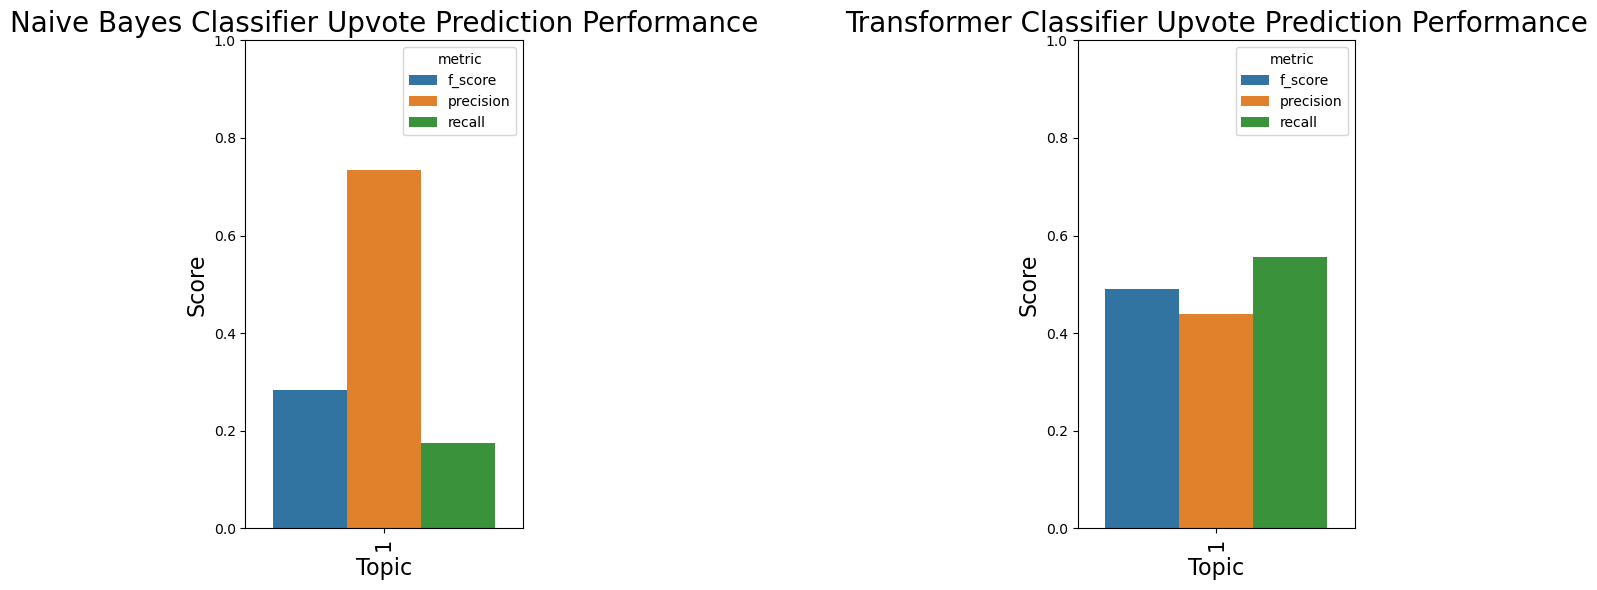

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

visualize_performance(nb_perf_df[nb_perf_df["class"] == 1],
                              ["f_score", "precision", "recall"],
                              use_class_names=False,
                              title="Naive Bayes Classifier Upvote Prediction Performance",
                              ax=axs[0],
                              ylim=[0, 1])

visualize_performance(trans_perf_df[trans_perf_df["class"] == 1],
                              ["f_score", "precision", "recall"],
                              use_class_names=False,
                              title="Transformer Classifier Upvote Prediction Performance",
                              ax=axs[1],
                              ylim=[0, 1])

plt.subplots_adjust(wspace=2.0)

### Analysis
When evaluating machine learning models dealing with classification tasks, we want to examine their precision, recall, and f1 scores. In this scenario, we have two classes: 0 and 1, where a 1 indicates that the response received an upvote and a 0 indicates that it didn’t. Moving forward, I will refer to the 1 and 0 as “Yes” and “No”, respectively. Because we care about how well the model predicts whether or not a response received an upvote or not, the metrics plotted above are for the “Yes’s”. The precision score is a measure of how many of the predicted Yes’s are actually Yes’s. In other words, it measures the proportion of true Yes’s (i.e., upvoted responses accurately predicted by the model) out of all the predicted Yes’s (i.e., responses predicted by the model to be upvoted). A high precision score indicates that the model is making accurate predictions of the upvoted responses, but it does not guarantee that all upvoted responses are correctly identified by the model. The recall score is a measure of how many of the actual Yes’s are correctly identified by the model. It measures the proportion of true Yes’s out of all actual Yes’s (i.e., responses that were actually upvoted in the test set). A high recall score indicates that the model is correctly identifying most of the upvoted responses, but it may also produce a significant number of false positives (i.e., responses predicted to be upvoted but were not actually upvoted). The f1 score is a weighted average of the precision and recall scores. This is a handy metric to evaluate the overall performance of the model.

We can see that the Naive Bayes classifier model has a precision score slightly greater than 0.7 and a recall score slightly less than 0.2, whereas the transformer model has a precision score slightly less than 0.4 and a recall score at around 0.55. Depending on the focus of the chatbot, a greater precision or recall score could be desired over the other. If a chatbot outputs a response to a question and we want to know if the user likes the response it produced, then we would prefer a model that yields a greater precision score if we care about the probability that the user likes the response if we tell the chatbot that the user likes it. We prefer a model with a higher recall score if we want to minimize the error of “humans don’t like the response but they actually do like it”.

I'd like to note that I experienced some variability in the precision, recall, and f1 scores of the transformer model after each training and predicting iteration. While I tried to troubleshoot this issue in the "setting seeds" block of code, I still experienced minor differences in these evaluation metrics after each run. A goal of mine moving forward is to gain a deeper knowledge of how these more complex language transformer models work in order to make more consistent and accurate predictions.

## Naive Bayes Classifier for Topic Classification

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

In [60]:
# Using GridSearch for optimal performance

X1 = data["answerText"]
y1 = data["topic"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)


cv1 = CountVectorizer(max_features=10000, stop_words="english")
X_train1 = cv1.fit_transform(X_train1)

tfidf1 = TfidfTransformer(use_idf=True)
X_train1 = tfidf1.fit_transform(X_train1)

X_test1 = cv1.transform(X_test1)
X_test1 = tfidf1.transform(X_test1)

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

clf1 = GridSearchCV(MultinomialNB(), param_grid, cv=5)
clf1.fit(X_train1, y_train1)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]})

In [61]:
# Using best alpha value

best_clf1 = clf1.best_estimator_
best_clf1.fit(X_train1, y_train1)

y_pred_test1 = best_clf1.predict(X_test1)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


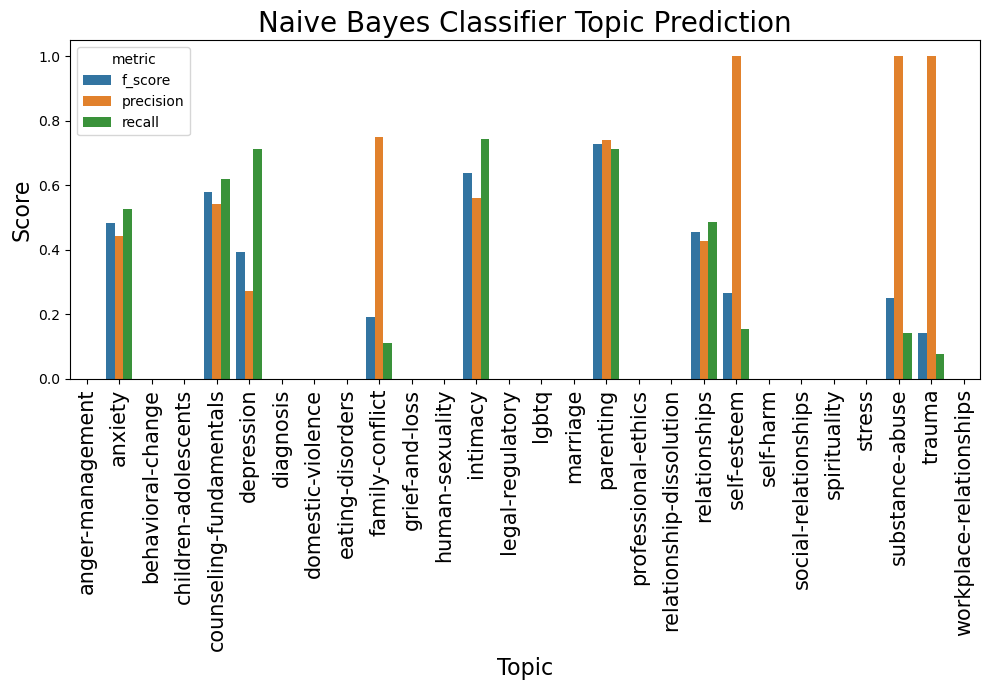

In [62]:
nb_perf_df1 = calculate_classification_metrics(y_test1, y_pred_test1)
nb_viz1 = visualize_performance(nb_perf_df1, ["f_score", "precision", "recall"], title="Naive Bayes Classifier Topic Prediction")

In [63]:
# Taking a closer look at "Depression" and "Anxiety"

topics_data = data[data["topic"].isin(["depression", "anxiety"])]

X = topics_data["answerText"]
y = topics_data["topic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


cv = CountVectorizer(max_features=10000, stop_words="english")
X_train = cv.fit_transform(X_train)

tfidf = TfidfTransformer(use_idf=True)
X_train = tfidf.fit_transform(X_train)

X_test = cv.transform(X_test)
X_test = tfidf.transform(X_test)

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

clf = GridSearchCV(MultinomialNB(), param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]})

In [64]:
best_clf = clf.best_estimator_
best_clf.fit(X_train, y_train)

y_pred_train = best_clf.predict(X_train)
y_pred_test = best_clf.predict(X_test)

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Assuming y_test is a numpy array containing the class labels
unique_classes, counts = np.unique(y_test, return_counts=True)
print("Number of instances of each class in y_test:")
for label, count in zip(unique_classes, counts):
    print("Class {} : {}".format(label, count))

Number of instances of each class in y_test:
Class anxiety : 45
Class depression : 71


In [66]:
confusion_matrix(y_test, y_pred_test)

array([[33, 12],
       [ 8, 63]])

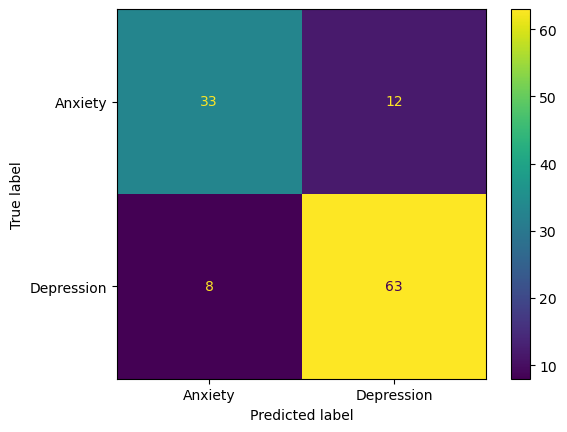

In [67]:
confusion_matrix = confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anxiety", "Depression"])

cm_display.plot()

font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 18}
plt.rc('font', **font)
        
plt.show()

### Analysis
We can see that our Naive Bayes classification model was not able to properly classify many responses to their respective topics. In fact, it didn’t even predict any instances of around half of the topics. However, it performed relatively well in the few topics that it was able to classify, such as “intimacy”, “parenting”, “counseling-fundamentals”. The model experiences a high precision to low recall ratio for classifying topics such as “family-conflict”, “self-esteem”, “substance-abuse”, and “trauma”. A high precision to low recall ratio indicates that the model was accurate in the predictions it made of the topic at hand and produced little false positives, but simply did not predict many relevant instances of the topic. This inconsistency can be due to the fact that we have 31 different classes, with many of them overlapping in content. It is very understandable that a simple model would face troubles distinguishing between these topics with the available data.

Upon taking a closer look at how the Naive Bayes classifier model understands the text data associated with "Depression" and "Anxiety", we can see where the overlapping content between these two topics presents an issue. "Depression" experiences a relatively high recall to low precision ratio, which indicates that the model correctly identified a large number of instances of this topic, but also generated a considerable number of false positives. The confusion matrix shows us that the model categorized 12 responses that were responding to "Anxiety" as "Depression". This misclassification issue is experienced the other way around as well.

## Conclusion
After conducting these analyses of this text dataset, we can see that although there are concrete results to work with and build off of, there is a lot of work to be done in terms of organization of text data, model selection, and model tuning to yield much better results. It seems as though the method used to identify the top TF-IDF words for each topic is effective, as the top words we saw are all compatible with their respective topics. We can see that the Naive Bayes classifier model yields a precision score of around 0.7 while the transformer model yields a recall score of around 0.55. These models obviously have different strengths and weaknesses in their capabilities of interpreting the input text and predicting upvotes. Moving forward, I could experiment with training a model that uses both algorithms to try to find the right balance and increase both precision and recall scores. Finally, topic classification with 31 output classes obviously seems to be a very complex task for any model to tackle. The Naive Bayes classifier model was only able to predict a handful of topics, and the metrics for those aren’t all that promising. This is an area where we can further examine and work on in the future.